Title: Reproduction of Spatial Accessibility of COVID-19 Healthcare Resources in Illinois
---

**Reproduction of**: Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA

Original study *by* Kang, J. Y., A. Michels, F. Lyu, Shaohua Wang, N. Agbodo, V. L. Freeman, and Shaowen Wang. 2020. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. International Journal of Health Geographics 19 (1):1–17. DOI:[10.1186/s12942-020-00229-x](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-020-00229-x).

Reproduction Authors: Joe Holler, Derrick Burt, and Kufre Udoh
With contributions from Peter Kedron, Drew An-Pham, and the Spring 2021 Open Source GIScience class at Middlebury

Reproduction Materials Available at: [github.com/HEGSRR/RPr-Kang-2020](https://github.com/HEGSRR/RPr-Kang-2020)

Created: `2021-06-01`
Revised: `2021-08-19`

### Original Data
To perform the ESFCA method, three types of data are required, as follows: (1) road network, (2) population, and (3) hospital information. The road network can be obtained from the [OpenStreetMap Python Library, called OSMNX](https://github.com/gboeing/osmnx). The population data is available on the [American Community Survey](https://data.census.gov/cedsci/deeplinks?url=https%3A%2F%2Ffactfinder.census.gov%2F&tid=GOVSTIMESERIES.CG00ORG01). Lastly, hospital information is also publically available on the [Homelanad Infrastructure Foundation-Level Data](https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals?geometry=-94.504%2C40.632%2C-80.980%2C43.486).

### Modules
Import necessary libraries to run this model.
See `environment.yml` for the library versions used for this analysis.

In [35]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
import re
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium
import itertools
import os
import time
import warnings
import IPython
import requests
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.0
pandas==1.3.5
geopandas==0.10.2
networkx==2.6.3
osmnx==1.1.2
re==2.2.1
folium==0.12.1.post1
IPython==8.3.0
requests==2.27.1
ipywidgets==7.6.5


## Check Directories

Because we have restructured the repository for replication, we need to check our working directory and make necessary adjustments.

In [36]:
# Check working directory
os.getcwd()

'/home/jovyan/work/RPr-Kang-2020'

In [37]:
# Use to set work directory properly
if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../../')
os.getcwd()

'/home/jovyan/work/RPr-Kang-2020'

## Load and Visualize Data

### Population and COVID-19 Cases Data by County

*'Cases' column is coming in as 'Unnamed_0' --> easy to rename but this probably should be reportede to the original authors*

If you would like to use the data generated from the pre-processing scripts, use the following code:

```py
covid_data = gpd.read_file('./data/raw/public/Pre-Processing/covid_pre-processed.shp')
atrisk_data = gpd.read_file('./data/raw/public/Pre-Processing/atrisk_pre-processed.shp')
```

In [38]:
# Read in at risk population data
atrisk_data = gpd.read_file('./data/raw/public/PopData/Illinois_Tract.shp')
atrisk_data.head()

,GEOID,STATEFP,COUNTYFP,TRACTCE,NAMELSAD,Pop,Unnamed_ 0,NAME,OverFifty,TotalPop,geometry
0,17091011700,17,091,011700,Census Tract 117,3688,588,"Census Tract 117, Kankakee County, Illinois",1135,3688,"POLYGON ((-87.88768 41.13594, -87.88764 41.136..."
1,17091011800,17,091,011800,Census Tract 118,2623,220,"Census Tract 118, Kankakee County, Illinois",950,2623,"POLYGON ((-87.89410 41.14388, -87.89400 41.143..."
2,17119400951,17,119,400951,Census Tract 4009.51,5005,2285,"Census Tract 4009.51, Madison County, Illinois",2481,5005,"POLYGON ((-90.11192 38.70281, -90.11128 38.703..."
3,17119400952,17,119,400952,Census Tract 4009.52,3014,2299,"Census Tract 4009.52, Madison County, Illinois",1221,3014,"POLYGON ((-90.09442 38.72031, -90.09360 38.720..."
4,17135957500,17,135,957500,Census Tract 9575,2869,1026,"Census Tract 9575, Montgomery County, Illinois",1171,2869,"POLYGON ((-89.70369 39.34803, -89.69928 39.348..."


In [39]:
# Read in covid case data
covid_data = gpd.read_file('./data/raw/public/PopData/Chicago_ZIPCODE.shp')
covid_data['cases'] = covid_data['cases']
covid_data.head()

,ZCTA5CE10,County,State,Join,ZONE,ZONENAME,FIPS,pop,cases,geometry
0,60660,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,43242,78,"POLYGON ((-87.65049 41.99735, -87.65029 41.996..."
1,60640,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,69715,117,"POLYGON ((-87.64645 41.97965, -87.64565 41.978..."
2,60614,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,71308,134,"MULTIPOLYGON (((-87.67703 41.91845, -87.67705 ..."
3,60712,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,12539,42,"MULTIPOLYGON (((-87.76181 42.00465, -87.76156 ..."
4,60076,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,31867,114,"MULTIPOLYGON (((-87.74782 42.01540, -87.74526 ..."


### Load Hospital Data

Note that 999 is treated as a "NULL"/"NA" so these hospitals are filtered out. This data contains the number of ICU beds and ventilators at each hospital.

In [40]:
# Read in hospital data
hospitals = gpd.read_file('./data/raw/public/HospitalData/Chicago_Hospital_Info.shp')
hospitals.head()

,FID,Hospital,City,ZIP_Code,X,Y,Total_Bed,Adult ICU,Total Vent,geometry
0,2,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.972800,145,36,12,MULTIPOINT (-87.67108 41.97280)
1,4,Advocate Christ Medical Center,Oak Lawn,60453,-87.732483,41.720281,785,196,64,MULTIPOINT (-87.73248 41.72028)
2,13,Evanston Hospital,Evanston,60201,-87.683288,42.065393,354,89,29,MULTIPOINT (-87.68329 42.06539)
3,24,AMITA Health Adventist Medical Center Hinsdale,Hinsdale,60521,-87.920116,41.805613,261,65,21,MULTIPOINT (-87.92012 41.80561)
4,25,Holy Cross Hospital,Chicago,60629,-87.690841,41.770001,264,66,21,MULTIPOINT (-87.69084 41.77000)


### Generate and Plot Map of Hospitals

In [41]:
# Plot hospital data
m = folium.Map(location=[41.85, -87.65], tiles='cartodbpositron', zoom_start=10)
for i in range(0, len(hospitals)):
    folium.CircleMarker(
      location=[hospitals.iloc[i]['Y'], hospitals.iloc[i]['X']],
      popup="{}{}\n{}{}\n{}{}".format('Hospital Name: ',hospitals.iloc[i]['Hospital'],
                                      'ICU Beds: ',hospitals.iloc[i]['Adult ICU'],
                                      'Ventilators: ', hospitals.iloc[i]['Total Vent']),
      radius=5,
      color='blue',
      fill=True,
      fill_opacity=0.6,
      legend_name = 'Hospitals'
    ).add_to(m)
legend_html =   '''<div style="position: fixed; width: 20%; heigh: auto;
                            bottom: 10px; left: 10px;
                            solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Legend<br>'''

m

### Load and Plot Hexagon Grids (500-meter resolution)

<AxesSubplot:>

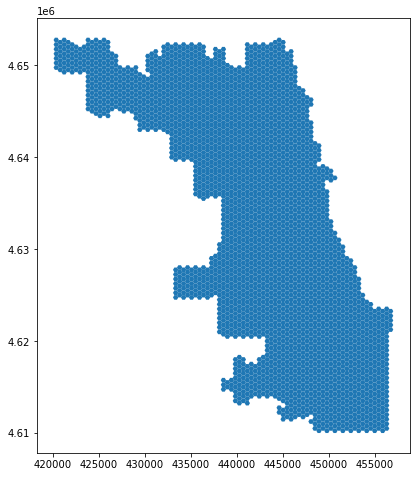

In [42]:
# Read in and plot grid file for Chicago
grid_file = gpd.read_file('./data/raw/public/GridFile/Chicago_Grid.shp')
grid_file.plot(figsize=(8,8))

### Load the Road Network

If `Chicago_Network_Buffer.graphml` does not already exist, this cell will query the road network from OpenStreetMap.  

Each of the road network code blocks may take a few mintues to run.

In [43]:
%%time
# To create a new graph from OpenStreetMap, delete or rename data/raw/private/Chicago_Network_Buffer.graphml 
# (if it exists), and set OSM to True 
OSM = False

# if buffered street network is not saved, and OSM is preferred, # generate a new graph from OpenStreetMap and save it
if not os.path.exists("./data/raw/private/Chicago_Network_Buffer.graphml") and OSM:
    print("Loading buffered Chicago road network from OpenStreetMap. Please wait... runtime may exceed 9min...", flush=True)
    G = ox.graph_from_place('Chicago', network_type='drive', buffer_dist=24140.2) 
    print("Saving Chicago road network to raw/private/Chicago_Network_Buffer.graphml. Please wait...", flush=True)
    ox.save_graphml(G, './data/raw/private/Chicago_Network_Buffer.graphml')
    print("Data saved.")

# otherwise, if buffered street network is not saved, download graph from the OSF project
elif not os.path.exists("./data/raw/private/Chicago_Network_Buffer.graphml"):
    print("Downloading buffered Chicago road network from OSF...", flush=True)
    url = 'https://osf.io/download/z8ery/'
    r = requests.get(url, allow_redirects=True)
    print("Saving buffered Chicago road network to file...", flush=True)
    open('./data/raw/private/Chicago_Network_Buffer.graphml', 'wb').write(r.content)

# if the buffered street network is already saved, load it
if os.path.exists("./data/raw/private/Chicago_Network_Buffer.graphml"):
    print("Loading buffered Chicago road network from raw/private/Chicago_Network_Buffer.graphml. Please wait...", flush=True)
    G = ox.load_graphml('./data/raw/private/Chicago_Network_Buffer.graphml') 
    print("Data loaded.") 
else:
    print("Error: could not load the road network from file.")

Loading buffered Chicago road network from raw/private/Chicago_Network_Buffer.graphml. Please wait...
Data loaded.
CPU times: user 39.9 s, sys: 645 ms, total: 40.5 s
Wall time: 40.3 s


### Plot the Road Network

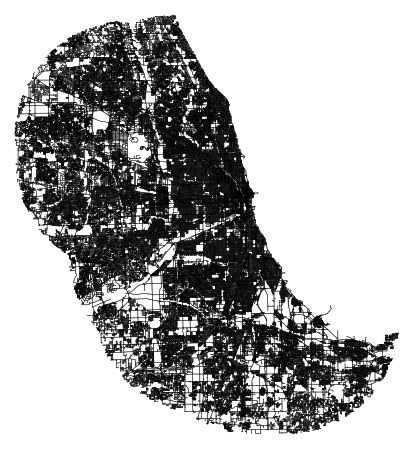

CPU times: user 1min 7s, sys: 307 ms, total: 1min 8s
Wall time: 1min 7s


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [44]:
%%time
ox.plot_graph(G, node_size = 1, bgcolor = 'white', node_color = 'black', edge_color = "#333333", node_alpha = 0.5, edge_linewidth = 0.5)

#### Check speed limit values

Display all the unique speed limit values and count how many network edges (road segments) have each value.
We will compare this to our cleaned network later.

In [45]:
%%time
# Turn nodes and edges into geodataframes
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Get unique counts of road segments for each speed limit
print(edges['maxspeed'].value_counts())
print(str(len(edges)) + " edges in graph")

# can we also visualize highways / roads with higher speed limits to check accuracy?
# the code above converts the graph into an edges geodataframe, which could theoretically be filtered
# by fast road segments and mapped, e.g. in folium

25 mph                        6016
30 mph                        4873
35 mph                        4803
20 mph                        3621
40 mph                        2842
45 mph                        2423
55 mph                         876
60 mph                         293
50 mph                         287
15 mph                         107
70 mph                          79
[45 mph, 40 mph]                54
10 mph                          44
65 mph                          36
[35 mph, 40 mph]                36
[35 mph, 30 mph]                36
[35 mph, 45 mph]                34
[45 mph, 55 mph]                29
45,30                           24
[45 mph, 50 mph]                19
25, east                        14
25                              14
[40 mph, 30 mph]                11
[30 mph, 25 mph]                 7
[35 mph, 20 mph]                 6
[35 mph, 25 mph]                 6
[25 mph, 30 mph]                 6
[60 mph, 55 mph]                 5
[65 mph, 60 mph]    

In [46]:
edges.head()

osmid oneway   lanes             ref  \
u      v          key                                                         
738776 768967302  0    [61699092, 918557247]   True  [4, 5]           I 294   
738920 348225363  0     [61431949, 31298719]   True       5       I 80;I 94   
739113 1875082688 0                 60862616   True       2             NaN   
       739130     0                292493273   True       4  I 80;I 94;US 6   
739117 739113     0                292493271   True       5  I 80;I 94;US 6   

                                     name        highway maxspeed    length  \
u      v          key                                                         
738776 768967302  0     Tri-State Tollway       motorway   55 mph   467.708   
738920 348225363  0    Kingery Expressway       motorway   55 mph  1220.747   
739113 1875082688 0                   NaN  motorway_link      NaN   549.609   
       739130     0     Borman Expressway       motorway   55 mph  1191.046   
739117 739113     0     Borman Expressway       motorway   55 mph   381.798   

                                                                geometry  \
u      v          key                                                      
738776 768967302  0    LINESTRING (-87.68109 41.58525, -87.68096 41.5...   
738920 348225363  0    LINESTRING (-87.56225 41.57764, -87.55790 41.5...   
739113 1875082688 0    LINESTRING (-87.34349 41.56738, -87.34277 41.5...   
       739130     0    LINESTRING (-87.34349 41.56738, -87.34104 41.5...   
739117 739113     0    LINESTRING (-87.34806 41.56768, -87.34689 41.5...   

                      bridge tunnel access junction width area service  
u      v          key                                                   
738776 768967302  0      NaN    NaN    NaN      NaN   NaN  NaN     NaN  
738920 348225363  0      yes    NaN    NaN      NaN   NaN  NaN     NaN  
739113 1875082688 0      NaN    NaN    NaN      NaN   NaN  NaN     NaN  
       739130     0      NaN    NaN    NaN      NaN   NaN  NaN     NaN  
739117 739113     0      NaN    NaN    NaN      NaN   NaN  NaN     NaN

### network_setting function

Cleans the OSMNX network to work better with drive-time analysis.

First, we remove all nodes with 0 outdegree because any hospital assigned to such a node would be unreachable from everywhere. Next, we remove small (under 10 node) *strongly connected components* to reduce erroneously small ego-centric networks. Lastly, we ensure that the max speed is set and in the correct units before calculating time.

Args:

* network: OSMNX network for the spatial extent of interest

Returns:

* OSMNX network: cleaned OSMNX network for the spatial extent

In [47]:
# two things about this function:
# 1) the work to remove nodes is hardly worth it now that OSMnx cleans graphs by default
# the function is now only pruning < 300 nodes
# 2) try using the OSMnx speed module for setting speeds, travel times
# https://osmnx.readthedocs.io/en/stable/user-reference.html#module-osmnx.speed
# osmnx.speed.add_edge_speeds(network, hwy_speeds=None, fallback=None, precision=None, agg=numpy.mean)

# just be careful about units of speed and time!
# the remainder of this code expects 'time' to be measured in minutes

# def network_setting(network):
#     _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])
#     network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
#     for component in list(nx.strongly_connected_components(network)):
#         if len(component)<10:
#             for node in component:
#                 _nodes_removed+=1
#                 network.remove_node(node)
#     for u, v, k, data in tqdm(G.edges(data=True, keys=True),position=0):
#         if 'maxspeed' in data.keys():
#             speed_type = type(data['maxspeed'])
#             if (speed_type==str):
#                 # Add in try/except blocks to catch maxspeed formats that don't fit Kang et al's cases
#                 try:
#                     if len(data['maxspeed'].split(','))==2:
#                         data['maxspeed_fix']=float(data['maxspeed'].split(',')[0])                  
#                     elif data['maxspeed']=='signals':
#                         data['maxspeed_fix']=30.0 # drive speed setting as 35 miles
#                     else:
#                         data['maxspeed_fix']=float(data['maxspeed'].split()[0])
#                 except:
#                     data['maxspeed_fix']=30.0 #miles
#             else:
#                 try:
#                     data['maxspeed_fix']=float(data['maxspeed'][0].split()[0])
#                 except:
#                     data['maxspeed_fix']=30.0 #miles
#         else:
#             data['maxspeed_fix']=30.0 #miles
#         data['maxspeed_meters'] = data['maxspeed_fix']*26.8223 # convert mile per hour to meters per minute
#         data['time'] = float(data['length'])/ data['maxspeed_meters'] # meters / meters per minute = minutes
#     print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
#     print("Number of nodes: {}".format(network.number_of_nodes()))
#     print("Number of edges: {}".format(network.number_of_edges()))    
#     return(network)

#import osmnx as osmnx

### Preprocess the Network using network_setting

In [48]:
%%time
# G, hospitals, grid_file, pop_data = file_import (population_dropdown.value)
# , hwy_speeds=None, fallback=None, precision=None, agg=np.mean
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)
# Create point geometries for each node in the graph, to make constructing catchment area polygons easier
for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])
# Modify code to react to processor dropdown (got rid of file_import function)

CPU times: user 44.5 s, sys: 159 ms, total: 44.6 s
Wall time: 44.4 s


#### Re-check speed limit values

Display all the unique speed limit values and count how many network edges (road segments) have each value.
Compare to the previous results.

In [49]:
%%time
## Get unique counts for each road network
# Turn nodes and edges in geodataframes
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Count
edges['speed_mph'] = edges['speed_kph']*0.621371
# G = ox.graph_from_gdfs(nodes, edges)
print(edges['speed_mph'].value_counts())
print(str(len(edges)) + " edges in graph")

23.363550    285280
29.701534     29184
35.356010     27968
37.717220      8894
24.979114      7015
30.012219      4873
34.983187      4803
20.008146      3621
40.016292      2842
44.987260      2423
25.786897      2412
51.822341      2304
54.991334       876
33.243349       468
60.024439       293
50.020366       287
55.550567       253
18.330444       240
42.128954       164
29.018026       145
14.975041       107
70.028512        79
42.253228        54
10.004073        44
39.767744        39
37.282260        38
32.311292        36
64.995407        36
49.709680        31
15.534275        28
28.148106        24
27.340324        19
47.224196        19
34.796776        11
22.369356         8
29.825808         8
52.195164         5
44.738712         5
57.166132         5
62.137100         5
12.427420         4
19.883872         4
59.651616         4
64.622584         4
32.932663         2
44.117341         2
42.874599         2
4.970968          2
27.961695         2
24.854840         1


## "Helper" Functions

The functions below are needed for our analysis later, let's take a look!

### hospital_setting

Finds the nearest network node for each hospital.

Args:

* hospital: GeoDataFrame of hospitals
* G: OSMNX network

Returns:

* GeoDataFrame of hospitals with info on nearest network node

In [51]:
def hospital_setting(hospitals, G):
    # Create an empty column 
    hospitals['nearest_osm']=None
    # Append the neaerest osm column with each hospitals neaerest osm node
    for i in tqdm(hospitals.index, desc="Find the nearest network node from hospitals", position=0):
        hospitals['nearest_osm'][i] = ox.get_nearest_node(G, [hospitals['Y'][i], hospitals['X'][i]], method='euclidean') # find the nearest node from hospital location
    print ('hospital setting is done')
    return(hospitals)

### pop_centroid

Converts geodata to centroids

Args:

* pop_data: a GeodataFrame
* pop_type: a string, either "pop" for general population or "covid" for COVID-19 case data

Returns:

* GeoDataFrame of centroids with population data

In [52]:
def pop_centroid (pop_data, pop_type):
    pop_data = pop_data.to_crs({'init': 'epsg:4326'})
    # If pop is selected in dropdown, select at risk pop where population is greater than 0
    if pop_type =="pop":
        pop_data=pop_data[pop_data['OverFifty']>=0]
    # If covid is selected in dropdown, select where covid cases are greater than 0
    if pop_type =="covid":
        pop_data=pop_data[pop_data['cases']>=0]
    pop_cent = pop_data.centroid # it make the polygon to the point without any other information
    # Convert to gdf
    pop_centroid = gpd.GeoDataFrame()
    i = 0
    for point in tqdm(pop_cent, desc='Pop Centroid File Setting', position=0):
        if pop_type== "pop":
            pop = pop_data.iloc[i]['OverFifty']
            code = pop_data.iloc[i]['GEOID']
        if pop_type =="covid":
            pop = pop_data.iloc[i]['cases']
            code = pop_data.iloc[i].ZCTA5CE10
        pop_centroid = pop_centroid.append({'code':code,'pop': pop,'geometry': point}, ignore_index=True)
        i = i+1
    return(pop_centroid)

### djikstra_cca_polygons

Function written by Joe Holler + Derrick Burt. It is a more efficient way to calculate distance-weighted catchment areas for each hospital. The algorithm runs quicker than the original one ("calculate_catchment_area"). It first creaets a dictionary (with a node and its corresponding drive time from the hospital) of all nodes within a 30 minute drive time (using single_cource_dijkstra_path_length function). From here, two more dictionaries are constructed by querying the original one. From this dictionaries, single part convex hulls are created for each drive time interval and appended into a single list (one list with 3 polygon geometries). Within the list, the polygons are differenced from each other to produce three catchment areas.

Args:
* G: cleaned network graph *with node point geometries attached*
* nearest_osm: A unique nearest node ID calculated for a single hospital
* distances: 3 distances (in drive time) to calculate catchment areas from
* distance_unit: unit to calculate (time)

Returns:
* A list of 3 diffrenced (not-overlapping) catchment area polygons (10 min poly, 20 min poly, 30 min poly)

In [65]:
def dijkstra_cca_polygons(G, nearest_osm, distances, distance_unit = "travel_time"):
    
    '''
    
    Before running: must assign point geometries to street nodes
    
    # create point geometries for the entire graph
    for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])
    
    '''
    
    ## CREATE DICTIONARIES
    # create dictionary of nearest nodes
    nearest_nodes_30 = nx.single_source_dijkstra_path_length(G, nearest_osm, distances[2], distance_unit) # creating the largest graph from which 10 and 20 minute drive times can be extracted from
    
    # extract values within 20 and 10 (respectively) minutes drive times
    nearest_nodes_20 = dict()
    nearest_nodes_10 = dict()
    for key, value in nearest_nodes_30.items():
        if value <= 20:
            nearest_nodes_20[key] = value
        if value <= 10:
            nearest_nodes_10[key] = value
    
    ## CREATE POLYGONS FOR 3 DISTANCE CATEGORIES (10 min, 20 min, 30 min)
    # 30 MIN
    # If the graph already has a geometry attribute with point data,
    # this line will create a GeoPandas GeoDataFrame from the nearest_nodes_30 dictionary
    points_30 = gpd.GeoDataFrame(gpd.GeoSeries(nx.get_node_attributes(G.subgraph(nearest_nodes_30), 'geometry')))

    # This line converts the nearest_nodes_30 dictionary into a Pandas data frame and joins it to points
    # left_index=True and right_index=True are options for merge() to join on the index values
    points_30 = points_30.merge(pd.Series(nearest_nodes_30).to_frame(), left_index=True, right_index=True)

    # Re-name the columns and set the geodataframe geometry to the geometry column
    points_30 = points_30.rename(columns={'0_x':'geometry','0_y':'z'}).set_geometry('geometry')

    # Create a convex hull polygon from the points
    polygon_30 = gpd.GeoDataFrame(gpd.GeoSeries(points_30.unary_union.convex_hull))
    polygon_30 = polygon_30.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # 20 MIN
    # Select nodes less than or equal to 1200
    points_20 = points_30.query("z <= 1200")
    
    # Create a convex hull polygon from the points
    polygon_20 = gpd.GeoDataFrame(gpd.GeoSeries(points_20.unary_union.convex_hull))
    polygon_20 = polygon_20.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # 10 MIN
    # Select nodes less than or equal to 600
    points_10 = points_30.query("z <= 600")
    
    # Create a convex hull polygon from the points
    polygon_10 = gpd.GeoDataFrame(gpd.GeoSeries(points_10.unary_union.convex_hull))
    polygon_10 = polygon_10.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # Create empty list and append polygons
    polygons = []
    
    # Append
    polygons.append(polygon_10)
    polygons.append(polygon_20)
    polygons.append(polygon_30)
    
    # Clip the overlapping distance ploygons (create two donuts + hole)
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")

    return polygons

### hospital_measure_acc (adjusted to incorporate dijkstra_cca_polygons)

Measures the effect of a single hospital on the surrounding area. (Uses `dijkstra_cca_polygons`)

Args:

* \_thread\_id: int used to keep track of which thread this is
* hospital: Geopandas dataframe with information on a hospital
* pop_data: Geopandas dataframe with population data
* distances: Distances in time to calculate accessibility for
* weights: how to weight the different travel distances

Returns:

* Tuple containing:
    * Int (\_thread\_id)
    * GeoDataFrame of catchment areas with key stats

In [54]:
def hospital_measure_acc (_thread_id, hospital, pop_data, distances, weights):
    # Create polygons
    polygons = dijkstra_cca_polygons(G, hospital['nearest_osm'], distances, distance_unit = "travel_time")
    
    # Calculate accessibility measurements
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        # Multiply polygons by weights
        for k in range(len(polygons)):
            if len(polygons[k]) > 0: # To exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['pop'][j]*weights[k])  
    total_pop = sum(num_pops)
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        polygons[i]['hospital_icu_beds'] = float(hospital['Adult ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i]['hospital_vents'] = float(hospital['Total Vent'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        polygons[i] = polygons[i].to_crs({'init':'epsg:32616'})
    print('{:.0f}'.format(_thread_id), end=" ", flush=True)
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ]) 

### measure_acc_par

Parallel implementation of accessibility measurement.

Args:

* hospitals: Geodataframe of hospitals
* pop_data: Geodataframe containing population data
* network: OSMNX street network
* distances: list of distances to calculate catchments for
* weights: list of floats to apply to different catchments
* num\_proc: number of processors to use.

Returns:

* Geodataframe of catchments with accessibility statistics calculated

In [55]:
def hospital_acc_unpacker(args):
    return hospital_measure_acc(*args)

# WHERE THE RESULTS ARE POOLED AND THEN REAGGREGATED
def measure_acc_par (hospitals, pop_data, network, distances, weights, num_proc = 4):
    catchments = []
    for distance in distances:
        catchments.append(gpd.GeoDataFrame())
    pool = mp.Pool(processes = num_proc)
    hospital_list = [ hospitals.iloc[i] for i in range(len(hospitals)) ]
    print("Calculating", len(hospital_list), "hospital catchments...\ncompleted number:", end=" ")
    results = pool.map(hospital_acc_unpacker, zip(range(len(hospital_list)), hospital_list, itertools.repeat(pop_data), itertools.repeat(distances), itertools.repeat(weights)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    for i in range(len(results)):
        for j in range(len(distances)):
            catchments[j] = catchments[j].append(results[i][j], sort=False)
    return catchments

### overlap_calc

Calculates and aggregates accessibility statistics for one catchment on our grid file.

Args:

* \_id: thread ID
* poly: GeoDataFrame representing a catchment area
* grid_file: a GeoDataFrame representing our grids
* weight: the weight to applied for a given catchment
* service_type: the service we are calculating for: ICU beds or ventilators

Returns:

* Tuple containing:
    * thread ID
    * Counter object (dictionary for numbers) with aggregated stats by grid ID number

In [56]:
# from collections import Counter
# def overlap_calc(_id, poly, grid_file, weight, service_type):
#     value_dict = Counter()
#     # Check if the service_type value of the first row in poly is not None
#     if type(poly.iloc[0][service_type])!=type(None):     
        
#         # Calculate the weighted value based on the service_type value in poly
#         value = float(poly[service_type])*weight
        
#         # Perform a spatial overlay between grid_file and poly
#         intersect = gpd.overlay(grid_file, poly, how='intersection')
        
#         # Calculate the area of the intersection and the percentage of overlap
#         intersect['overlapped']= intersect.area
#         intersect['percent'] = intersect['overlapped']/intersect['area']
        
#         # Filter the intersected polygons where the overlap percentage is greater than or equal to 50%
#         #intersect=intersect[intersect['percent']>=0.5]
        
        
        
#         intersect_region = intersect['id']
#         for intersect_id in intersect_region:
#             #percent_value = intersect['percent'].iloc[intersect_id]
#             # Get all the rows that have the same ID, which are the small fragments in a hexagon
#             desired_id_rows = intersect[intersect_region == intersect_id]
#             percent_value = desired_id_rows['percent'].iloc[0] # the percentage of area cover of the id
#             try:
#                 value_dict[intersect_id] +=value * percent_value
#             except:
#                 value_dict[intersect_id] = value * percent_value
#     return(_id, value_dict)

# def overlap_calc_unpacker(args):
#     return overlap_calc(*args)

from collections import Counter
def overlap_calc(_id, poly, grid_file, weight, service_type):
    value_dict = Counter()
    if type(poly.iloc[0][service_type])!=type(None):           
        value = float(poly[service_type])*weight
        intersect = gpd.overlay(grid_file, poly, how='intersection')
        intersect['overlapped']= intersect.area
        intersect['percent'] = intersect['overlapped']/intersect['area']
        intersect=intersect[intersect['percent']>=0.5]
        intersect_region = intersect['id']
        for intersect_id in intersect_region:
            try:
                value_dict[intersect_id] +=value
            except:
                value_dict[intersect_id] = value
    return(_id, value_dict)

def overlap_calc_unpacker(args):
    return overlap_calc(*args)

### overlapping_function

Calculates how all catchment areas overlap with and affect the accessibility of each grid in our grid file.

Args:

* grid_file: GeoDataFrame of our grid
* catchments: GeoDataFrame of our catchments
* service_type: the kind of care being provided (ICU beds vs. ventilators)
* weights: the weight to apply to each service type
* num\_proc: the number of processors

Returns:

* Geodataframe - grid\_file with calculated stats

In [57]:
def overlapping_function (grid_file, catchments, service_type, weights, num_proc = 4):
    grid_file[service_type]=0
    pool = mp.Pool(processes = num_proc)
    acc_list = []
    for i in range(len(catchments)):
        acc_list.extend([ catchments[i][j:j+1] for j in range(len(catchments[i])) ])
    acc_weights = []
    for i in range(len(catchments)):
        acc_weights.extend( [weights[i]]*len(catchments[i]) )
    results = pool.map(overlap_calc_unpacker, zip(range(len(acc_list)), acc_list, itertools.repeat(grid_file), acc_weights, itertools.repeat(service_type)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    service_values = results[0]
    for result in results[1:]:
        service_values+=result
    for intersect_id, value in service_values.items():
        grid_file.loc[grid_file['id']==intersect_id, service_type] += value
    return(grid_file) 

### normalization

Normalizes our result (Geodataframe) for a given resource (res).

In [58]:
def normalization (result, res):
    result[res]=(result[res]-min(result[res]))/(max(result[res])-min(result[res]))
    return result

### file_import

Imports all files we need to run our code and pulls the Illinois network from OSMNX if it is not present (will take a while). 

**NOTE:** even if we calculate accessibility for just Chicago, we want to use the Illinois network (or at least we should not use the Chicago network) because using the Chicago network will result in hospitals near but outside of Chicago having an infinite distance (unreachable because roads do not extend past Chicago).

Args:

* pop_type: population type, either "pop" for general population or "covid" for COVID-19 cases
* region: the region to use for our hospital and grid file ("Chicago" or "Illinois")

Returns:

* G: OSMNX network
* hospitals: Geodataframe of hospitals
* grid_file: Geodataframe of grids
* pop_data: Geodataframe of population

In [59]:
def output_map(output_grid, base_map, hospitals, resource):
    ax=output_grid.plot(column=resource, cmap='PuBuGn',figsize=(18,12), legend=True, zorder=1)
    # Next two lines set bounds for our x- and y-axes because it looks like there's a weird 
    # Point at the bottom left of the map that's messing up our frame (Maja)
    ax.set_xlim([314000, 370000])
    ax.set_ylim([540000, 616000])
    base_map.plot(ax=ax, facecolor="none", edgecolor='gray', lw=0.1)
    hospitals.plot(ax=ax, markersize=10, zorder=1, c='blue')

### Run the model

Below you can customize the input of the model:

* Processor - the number of processors to use
* Region - the spatial extent of the measure
* Population - the population to calculate the measure for
* Resource - the hospital resource of interest
* Hospital - all hospitals or subset to check code

In [60]:
import ipywidgets
from IPython.display import display

processor_dropdown = ipywidgets.Dropdown( options=[("1", 1), ("2", 2), ("3", 3), ("4", 4)],
    value = 4, description = "Processor: ")

population_dropdown = ipywidgets.Dropdown( options=[("Population at Risk", "pop"), ("COVID-19 Patients", "covid") ],
    value = "pop", description = "Population: ")

resource_dropdown = ipywidgets.Dropdown( options=[("ICU Beds", "hospital_icu_beds"), ("Ventilators", "hospital_vents") ],
    value = "hospital_icu_beds", description = "Resource: ")

hospital_dropdown =  ipywidgets.Dropdown( options=[("All hospitals", "hospitals"), ("Subset", "hospital_subset") ],
    value = "hospitals", description = "Hospital:")

display(processor_dropdown,population_dropdown,resource_dropdown,hospital_dropdown)

Dropdown(description='Processor: ', index=3, options=(('1', 1), ('2', 2), ('3', 3), ('4', 4)), value=4)

Dropdown(description='Population: ', options=(('Population at Risk', 'pop'), ('COVID-19 Patients', 'covid')), …

Dropdown(description='Resource: ', options=(('ICU Beds', 'hospital_icu_beds'), ('Ventilators', 'hospital_vents…

Dropdown(description='Hospital:', options=(('All hospitals', 'hospitals'), ('Subset', 'hospital_subset')), val…

### Process population data

In [26]:
if population_dropdown.value == "pop":
    pop_data = pop_centroid(atrisk_data, population_dropdown.value)
elif population_dropdown.value == "covid":
    pop_data = pop_centroid(covid_data, population_dropdown.value)
distances=[600,1200,1800] # Distances in travel time
weights=[1.0, 0.68, 0.22] # Weights where weights[0] is applied to distances[0]
# Other weighting options representing different distance decays
# weights1, weights2, weights3 = [1.0, 0.42, 0.09], [1.0, 0.75, 0.5], [1.0, 0.5, 0.1]
# it is surprising how long this function takes just to calculate centroids.
# why not do it with the geopandas/pandas functions rather than iterating through every item?

Pop Centroid File Setting: 100%|██████████| 3121/3121 [05:07<00:00, 10.15it/s]


### Process hospital data
If you have already run this code and changed the Hospital selection, rerun the Load Hospital Data block.

In [62]:
# Set hospitals according to hospital dropdown
if hospital_dropdown.value == "hospital_subset":
    hospitals = hospital_setting(hospitals[:1], G)
else: 
    hospitals = hospital_setting(hospitals, G)
resources = ["hospital_icu_beds", "hospital_vents"] # resources
# this is also slower than it needs to be; if network nodes and hospitals are both
# geopandas data frames, it should be possible to do a much faster spatial join rather than iterating through every hospital

Find the nearest network node from hospitals: 100%|██████████| 66/66 [01:37<00:00,  1.48s/it]

hospital setting is done


In [32]:
G.nodes[180243301]

{'y': 41.5441586, 'x': -87.3545574, 'street_count': 4}

### Visualize catchment areas for first hospital

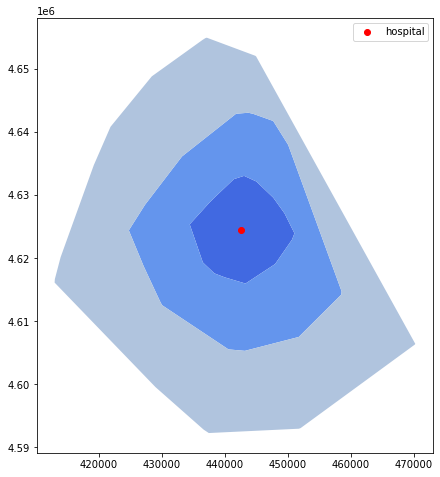

In [66]:
# Create point geometries for entire graph
# what is the pupose of the following two lines? Can this be deleted?
# for node, data in G.nodes(data=True):
#     data['geometry']=Point(data['x'], data['y'])

# which hospital to visualize? 
fighosp = 4

# Create catchment for hospital 0
poly = dijkstra_cca_polygons(G, hospitals['nearest_osm'][fighosp], distances, distance_unit = "travel_time")

# Reproject polygons
for i in range(len(poly)):
    poly[i].crs = { 'init' : 'epsg:4326'}
    poly[i] = poly[i].to_crs({'init':'epsg:32616'})

# Reproject hospitals 
# Possible to map from the hospitals data rather than creating hospital_subset?
hospital_subset = hospitals.iloc[[fighosp]].to_crs(epsg=32616)

fig, ax = plt.subplots(figsize=(12,8))

min_10 = poly[0].plot(ax=ax, color="royalblue", label="10 min drive")
min_20 = poly[1].plot(ax=ax, color="cornflowerblue", label="20 min drive")
min_30 = poly[2].plot(ax=ax, color="lightsteelblue", label="30 min drive")

hospital_subset.plot(ax=ax, color="red", legend=True, label = "hospital")

# Add legend
ax.legend()

In [67]:
poly

[                                            geometry
 0  POLYGON ((443313.505 4615987.097, 440030.033 4...,
                                             geometry
 0  POLYGON ((440613.946 4605536.814, 430073.865 4...,
                                             geometry
 0  POLYGON ((436676.631 4592805.072, 429027.439 4...]

### Calculate hospital catchment areas

In [68]:
%%time
catchments = measure_acc_par(hospitals, pop_data, G, distances, weights, num_proc=processor_dropdown.value)

Calculating 66 hospital catchments...
completed number: 0 15 5 10 6 1 16 11 2 7 17 12 18 3 8 13 4 9 19 14 25 30 20 35 26 31 21 36 32 27 37 22 28 38 33 23 39 29 34 24 40 45 55 50 46 41 56 51 47 42 57 52 48 43 58 53 44 49 59 54 60 65 61 62 63 64 CPU times: user 3.29 s, sys: 1.02 s, total: 4.31 s
Wall time: 2min 36s


### Calculate accessibility

In [69]:
%%time
for j in range(len(catchments)):
    catchments[j] = catchments[j][catchments[j][resource_dropdown.value]!=float('inf')]
result=overlapping_function(grid_file, catchments, resource_dropdown.value, weights, num_proc=processor_dropdown.value)

CPU times: user 8.77 s, sys: 795 ms, total: 9.57 s
Wall time: 25.3 s


In [70]:
%%time
result = normalization (result, resource_dropdown.value)

CPU times: user 2.68 ms, sys: 9 µs, total: 2.69 ms
Wall time: 2.49 ms


In [71]:
result.head()

,left,top,right,bottom,id,area,geometry,hospital_icu_beds
0,440843.416087,4.638515e+06,441420.766356,4.638015e+06,4158,216661.173,"POLYGON ((440843.416 4638265.403, 440987.754 4...",0.925023
1,440843.416087,4.638015e+06,441420.766356,4.637515e+06,4159,216661.168,"POLYGON ((440843.416 4637765.403, 440987.754 4...",0.947180
2,440843.416087,4.639515e+06,441420.766356,4.639015e+06,4156,216661.169,"POLYGON ((440843.416 4639265.403, 440987.754 4...",0.952311
3,440843.416087,4.639015e+06,441420.766356,4.638515e+06,4157,216661.171,"POLYGON ((440843.416 4638765.403, 440987.754 4...",0.933090
4,440843.416087,4.640515e+06,441420.766356,4.640015e+06,4154,216661.171,"POLYGON ((440843.416 4640265.403, 440987.754 4...",0.940914


### Area Weighted Reaggregation Function Attempt

Here I am presenting my version of overlapping calculation function on the population data using area weighted reaggregation method. Future work should prioritize improving this function.  

In [78]:
from collections import Counter
def overlap_calc_1(_id, poly, grid_file, weight, service_type):
    value_dict = Counter()
    # Check if the service_type value of the first row in poly is not None
    if type(poly.iloc[0][service_type])!=type(None):     
        
        # Calculate the weighted value based on the service_type value in poly
        value = float(poly[service_type])*weight
        
        # Perform a spatial overlay between grid_file and poly
        intersect = gpd.overlay(grid_file, poly, how='intersection')
        
        # Calculate the area of the intersection and the percentage of overlap
        intersect['overlapped']= intersect.area
        intersect['percent'] = intersect['overlapped']/intersect['area']
        
        # Filter the intersected polygons where the overlap percentage is greater than or equal to 50%
        #intersect=intersect[intersect['percent']>=0.5]
        
        intersect_region = intersect['id']
        for intersect_id in intersect_region:
            #percent_value = intersect['percent'].iloc[intersect_id]
            # Get all the rows that have the same ID, which are the small fragments in a hexagon
            desired_id_rows = intersect[intersect_region == intersect_id]
            percent_value = desired_id_rows['percent'].iloc[0] # the percentage of area cover of the id
            try:
                value_dict[intersect_id] +=value * percent_value
            except:
                value_dict[intersect_id] += value * percent_value
    return(_id, value_dict)

def overlap_calc_unpacker_1(args):
    return overlap_calc_1(*args)

def overlapping_function_1 (grid_file, catchments, service_type, weights, num_proc = 4):
    grid_file[service_type]=0
    pool = mp.Pool(processes = num_proc)
    acc_list = []
    for i in range(len(catchments)):
        acc_list.extend([ catchments[i][j:j+1] for j in range(len(catchments[i])) ])
    acc_weights = []
    for i in range(len(catchments)):
        acc_weights.extend( [weights[i]]*len(catchments[i]) )
    results = pool.map(overlap_calc_unpacker_1, zip(range(len(acc_list)), acc_list, itertools.repeat(grid_file), acc_weights, itertools.repeat(service_type)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    service_values = results[0]
    for result in results[1:]:
        service_values+=result
    for intersect_id, value in service_values.items():
        grid_file.loc[grid_file['id']==intersect_id, service_type] += value
    return(grid_file) 


result_1=overlapping_function_1(grid_file, catchments, resource_dropdown.value, weights, num_proc=processor_dropdown.value)

In [79]:
result = normalization (result, resource_dropdown.value)

### Results & Discussion


In the reanalysis study, we modified the road speed limit data using OSMNX. After scrutinizing the speed limit data of OpenStreetMap, we found that the majority of roads in the dataset do not have speed limit data included. The original study assigns a 35 mph speed limit to all road segments without speed limit data. This imputation method creates data that deviates greatly from reality, resulting in a road map where vehicles can only drive at 35 mph on most roads. The OSMNX package we utilized in our reanalysis overcomes the missing speed limit data problem by assigning speed limits to segments based on their road type. OSMNX assigns the mean speed limit of the same road type to the missing road segment while maintaining the same speed limit data for roads that already have them. This method creates a road map dataset that is more realistic and nuanced.

Although we improved the road map dataset by assigning more reasonable speed limit data, we have to admit that space-time interaction threats to validity still remain. The road map does not take into account temporal impacts on the road network, such as traffic jams during rush hours and road maintenance/construction. For patients who want to go to a hospital during the morning rush hours, they may prefer to drive to a further hospital on the outskirts of the city than a nearer hospital that is closer to the city downtown where people are commuting. The study also assumes that private cars are the only mode of transportation for patients traveling to hospitals, but in fact, some of them may choose public transportation.

The study is also vulnerable to other validity threats. Partition distortion, for example, is reflected in the representation of the population as centroids of census blocks. It oversimplifies the spatial distribution of the population in the Chicago area. In the original study, the hospital catchment area had to overlap more than 50 percent of a census polygon to include all the population in the population census in the catchment area. We intended to mitigate the validity threats by incorporating area-weighted reaggregation (AWR) to refine the calculation of the population in the catchment area. Instead of including all or none of the population in the census block that is partially covered by the catchment area, the area-weighted reaggregation method adds population to the census block by adding the population of the census block multiplied by the percentage area that is covered by the catchment area. Further development of the AWR function is needed.

Another validity threat may be attributed to boundary distortions. The study and the reproduction counteract the effect of boundary distortion by including road maps and hospitals within a 15-mile buffer of the Chicago area. However, the study does not include hospitals that are outside of Illinois when analyzing at the scale of the state. The results may not reflect the real healthcare service scenario, especially in cities like East Saint Louis where there are more medical resources across the state border.


### Accessibility Map

CPU times: user 2.9 s, sys: 286 ms, total: 3.19 s
Wall time: 2.86 s


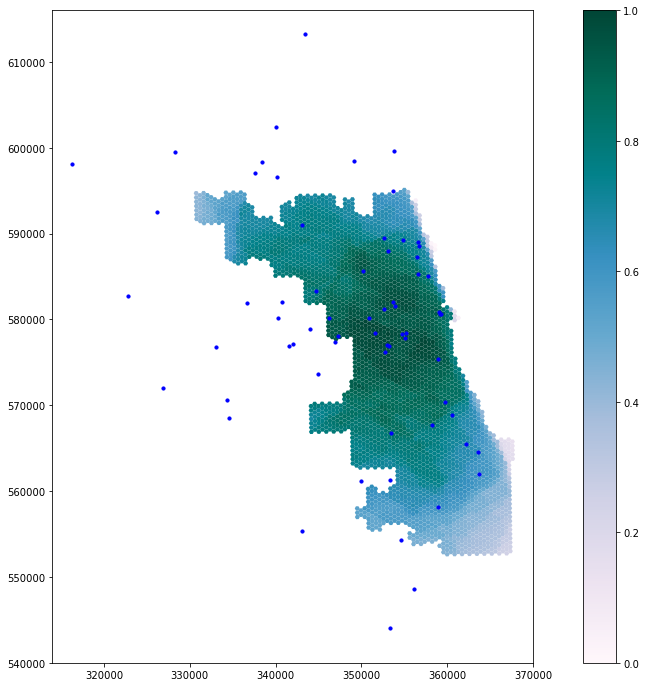

In [72]:
%%time
hospitals = hospitals.to_crs({'init': 'epsg:26971'})
result = result.to_crs({'init': 'epsg:26971'})
output_map(result, pop_data, hospitals, resource_dropdown.value)

### Area Weighted Reaggregation Map

This is the map generated by the function using area weighted reaggregation method. The scale of the score is not consistent with the map above. 

CPU times: user 4.45 s, sys: 440 ms, total: 4.89 s
Wall time: 4.29 s


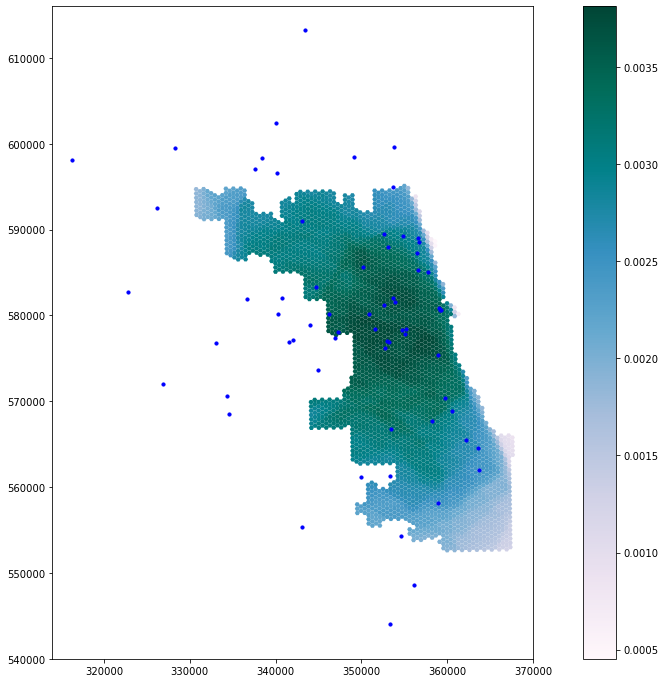

In [77]:
%%time
hospitals = hospitals.to_crs({'init': 'epsg:26971'})
result_1 = result_1.to_crs({'init': 'epsg:26971'})
output_map(result_1, pop_data, hospitals, resource_dropdown.value)

Classified Accessibility Outputs

### Conclusion

The graph above illustrates the accessibility score, considering the population at risk in each population census and the number of ICU beds in Chicago area hospitals. The central and northern parts of Chicago have significantly higher accessibility scores to medical resources compared to the southern part. In this reproduction and replication study, we changed the speed limit data of the Chicago network using OSMNX, creating a more detailed and accurate model of road speed than the original study. The general pattern of the Chicago area's accessibility did not change too much compared with the graph before changing the speed limit. The catchment area population calculation method should be improved by leveraging average weighted reaggregation in the future.

### References

Luo, W., & Qi, Y. (2009). An enhanced two-step floating catchment area (E2SFCA) method for measuring spatial accessibility to primary care physicians. Health & place, 15(4), 1100-1107.